# Gentle introduction to Pytorch Symbolic

You don't need any knowledge of the inner workings of Pytorch Symbolic to use it.
In most cases, after seeing a few examples, you're good to go.
If you used Keras Symbolic API before, you don't even need any learning materials.
However, this notebooks explains Pytorch Symbolic a little bit deeper, in case you just want to know more stuff.

In this notebook, we'll use our built-in drawing solution designed for layered graphs.
It will be helpful to see the exact data flow in the model.

You can use this tool yourself if you have optional dependencies installed:
* `networkx`
* `matplotlib`
* `scipy`.

They can be installed with `pip install pytorch-symbolic[full]`.

* [Link to Documentation](https://pytorch-symbolic.readthedocs.io/en/latest/quick_start/)

In [1]:
!pip install "pytorch-symbolic[full]" torchvision tqdm

In [2]:
import torch
from torch import nn
from pytorch_symbolic import SymbolicModel, Input, useful_layers, graph_algorithms

import matplotlib.pyplot as plt

import torchvision
from tqdm.notebook import tqdm

## Having fun with Symbolic Data
### Simple example
We'll first look at what happens when we interact with Symbolic Data.

Specifically, we will work on Symbolic Tensors which are a special case of Symbolic Data. They have similar API to `torch.Tensor`.

In [3]:
x = Input(shape=(5,))
y = Input(shape=(5,))
print(f"x={x}")
print(f"y={y}")
print()

z = x + y
print("After creating z = x + y:")
print(f"x={x}")
print(f"y={y}")
print(f"z={z}")

x=<SymbolicTensor at 0x7f3178dd2520; 0 parents; 0 children>
y=<SymbolicTensor at 0x7f322c366bb0; 0 parents; 0 children>

After creating z = x + y:
x=<SymbolicTensor at 0x7f3178dd2520; 0 parents; 1 children>
y=<SymbolicTensor at 0x7f322c366bb0; 0 parents; 1 children>
z=<SymbolicTensor at 0x7f322c3c2760; 2 parents; 0 children>


We created two Symbolic Tensors: `x` and `y`.
Their sum is represented by another Symbolic Tensor: `z`, which was added to the graph of computations.

When we print the tensors, we can see that `z` has two parents and both `x` and `y` have one child.

If we need, we can even retrieve the instances of specific children and parents.

As it is in life, you cannot change your parents, thus `.parents` are immutable.
But `.children` will be modified when performing new operations.

In [4]:
print(f"x.children={x.children}")
print(f"y.children={y.children}")

print(f"z.parents={z.parents}")

x.children=(<SymbolicTensor at 0x7f322c3c2760; 2 parents; 0 children>,)
y.children=(<SymbolicTensor at 0x7f322c3c2760; 2 parents; 0 children>,)
z.parents=(<SymbolicTensor at 0x7f3178dd2520; 0 parents; 1 children>, <SymbolicTensor at 0x7f322c366bb0; 0 parents; 1 children>)


We are creating full fledged graphs now! Let's try to plot them...

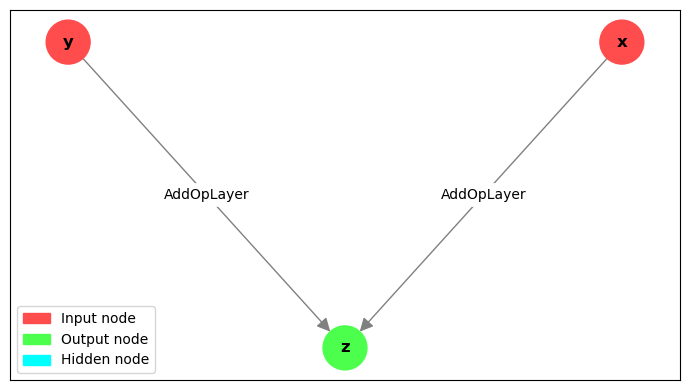

In [5]:
# To show you nicer plot, we prepared an option to show variable names in nodes of the graph.
# It requires passing the namespace containing the variables, e.g. globals().
# By default, you'll see shape of the underlying Symbolic Tensor instead.

graph_algorithms.draw_graph(inputs=(x, y), outputs=z, node_text_namespace=globals(), figsize=(7, 4));

We can see that addition was converted to `AddOpLayer`.

If we want to use a custom function on a symbolic tensor, we should create a `torch.nn.Module`.

Simple operators like additions or object's methods will work out of the box.

### A deeper example

We will create another, more complicated model.

Still no neural networks, but we'll get to them eventually.

In [6]:
x = Input(shape=())
y = Input(shape=())

sums = x + y
diff = x - y
mult = x * y
intermediate_values = [sums, diff, mult]
outputs = sum(intermediate_values) / 3

In [7]:
intermediate_values

[<SymbolicTensor at 0x7f314315d5e0; 2 parents; 1 children>,
 <SymbolicTensor at 0x7f317710c7c0; 2 parents; 1 children>,
 <SymbolicTensor at 0x7f314315d1f0; 2 parents; 1 children>]

We can see that the three intermediate values have 2 parents and 1 child.

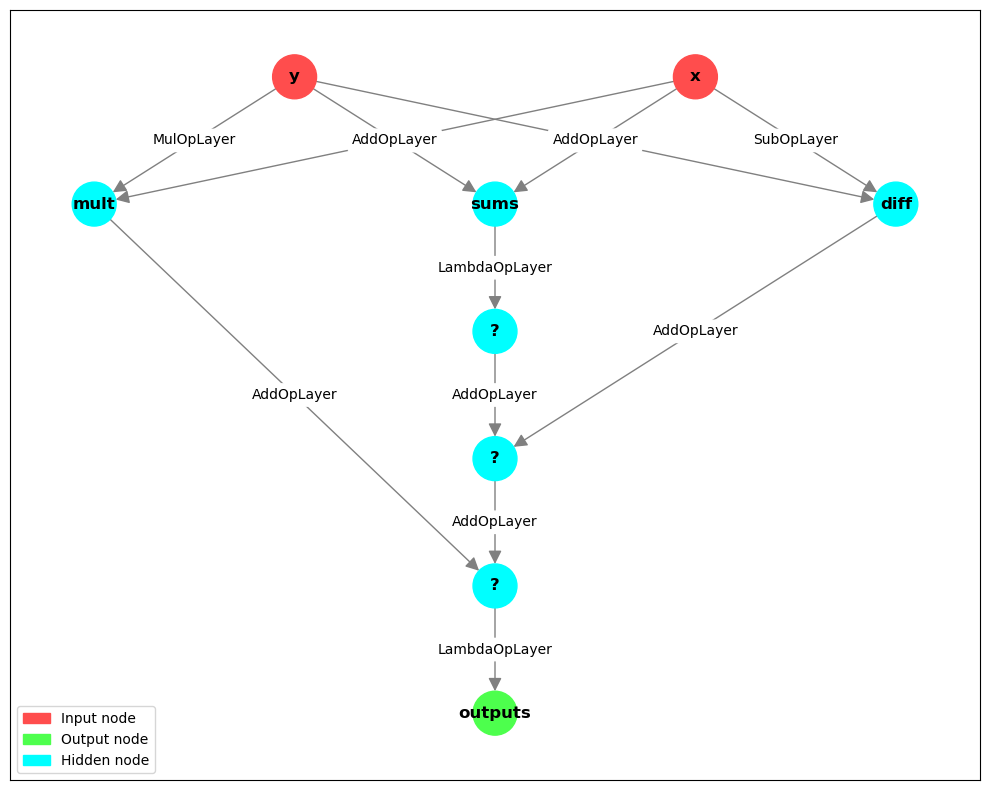

In [8]:
graph_algorithms.draw_graph(inputs=(x, y), outputs=outputs, node_text_namespace=globals(), figsize=(10, 8));

Moreover, we see what Python does internally, when `sum` is called. It's just a bunch of additions represented by `AddOpLayer`!

Let us create a Symbolic Model from this graph!

In [9]:
model = SymbolicModel(inputs=(x, y), outputs=outputs)
model.summary()

________________________________________________________
     Layer             Output shape   Params   Parent   
1    Input_1           (None,)        0                 
2    Input_2           (None,)        0                 
3    AddOpLayer_1      (None,)        0        1,2      
4    SubOpLayer_1      (None,)        0        1,2      
5    MulOpLayer_1      (None,)        0        1,2      
6    LambdaOpLayer_1   (None,)        0        3        
7    AddOpLayer_2      (None,)        0        6,4      
8    AddOpLayer_3      (None,)        0        7,5      
9*   LambdaOpLayer_2   (None,)        0        8        
Total params: 0
Trainable params: 0
Non-trainable params: 0
________________________________________________________


This model has no parameters. Let us use it on random data:

In [10]:
rx = torch.rand(
    1,
)
ry = torch.rand(
    1,
)

print(f"rx={rx}")
print(f"ry={ry}")
print(f"model(rx, ry)={model(rx, ry)}")

assert model(rx, ry) == ((rx + ry) + (rx - ry) + (rx * ry)) / 3, "Something went wrong..."

rx=tensor([0.7853])
ry=tensor([0.7484])
model(rx, ry)=tensor([0.7194])


As we see, after defining the model on Symbolic Tensors it works perfectly fine launched on real data!

Right now, we were manipulating the data with `+`, `-` and `*` operators.

Most of Python's operators are already defined for Symbolic Tensors, e.g.: `+, -, *, /, //, %, abs`.

They will be converted to ``torch.nn.Module`` and registered correctly in the model.

## Symbolic Tensors and PyTorch Layers

In deep learning, we rarely use just standard, non-parametrized operations.
Instead, we rely on layers to transform the data.
Let's create a small linear model with a few hidden layers!

In [11]:
inputs = Input(shape=(4,))
x1 = nn.Linear(inputs.features, 10)(inputs)
x2 = nn.Linear(x1.features, 10)(x1)
x3 = nn.Linear(x2.features, 10)(x2)
outputs = nn.Linear(x3.features, 1)(x3)

model = SymbolicModel(inputs, outputs)
model.summary()

_________________________________________________
     Layer      Output shape   Params   Parent   
1    Input_1    (None, 4)      0                 
2    Linear_1   (None, 10)     50       1        
3    Linear_2   (None, 10)     110      2        
4    Linear_3   (None, 10)     110      3        
5*   Linear_4   (None, 1)      11       4        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________


Looks like it was a succes. Let's see how it looks like as a graph!

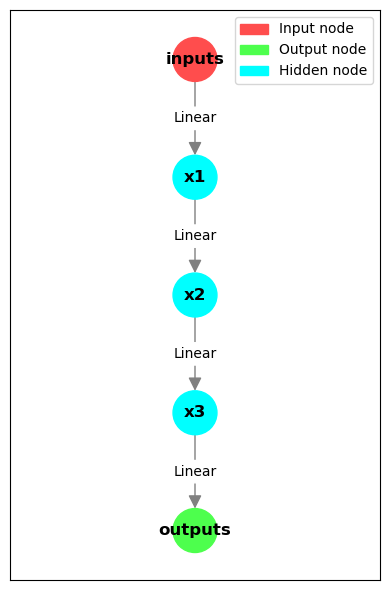

In [12]:
graph_algorithms.draw_graph(model=model, node_text_namespace=globals(), figsize=(4, 6));

It's a rather simple topology.

### An odd one

We'll now create a model that consists of a few towers - separate Symbolic Models.

It means we will use Symbolic Models inside another Symbolic Model. Cool, isn't it?

There'll be:
* 3 separate inputs
* 2 separate outputs

After a few layers of separated computations, the results will be concatenated, then transformed some more and returned.

On the drawing we will display the shapes of Symbolic Tensors.

In [13]:
def get_tower(height):
    inputs = x = Input((5,))
    for _ in range(height):
        x = nn.Linear(x.features, 10)(x)
    model = SymbolicModel(inputs, x)
    return model


towers = [get_tower(height=3 + i) for i in range(3)]
inputs = [Input((5,)) for _ in range(3)]
tower_outputs = []

for x, tower in zip(inputs, towers):
    tower_outputs.append(tower(x))

x = useful_layers.ConcatLayer(dim=1)(*tower_outputs)

out1 = nn.Linear(x.features, 5)(x)
out2 = nn.Linear(x.features, 3)(x)

model = SymbolicModel(inputs, (out1, out2))
model.summary()

________________________________________________________
     Layer             Output shape   Params   Parent   
1    Input_1           (None, 5)      0                 
2    Input_2           (None, 5)      0                 
3    Input_3           (None, 5)      0                 
4    SymbolicModel_1   (None, 10)     280      1        
5    SymbolicModel_2   (None, 10)     390      2        
6    SymbolicModel_3   (None, 10)     500      3        
7    ConcatLayer_1     (None, 30)     0        4,5,6    
8*   Linear_1          (None, 5)      155      7        
9*   Linear_2          (None, 3)      93       7        
Total params: 1418
Trainable params: 1418
Non-trainable params: 0
________________________________________________________


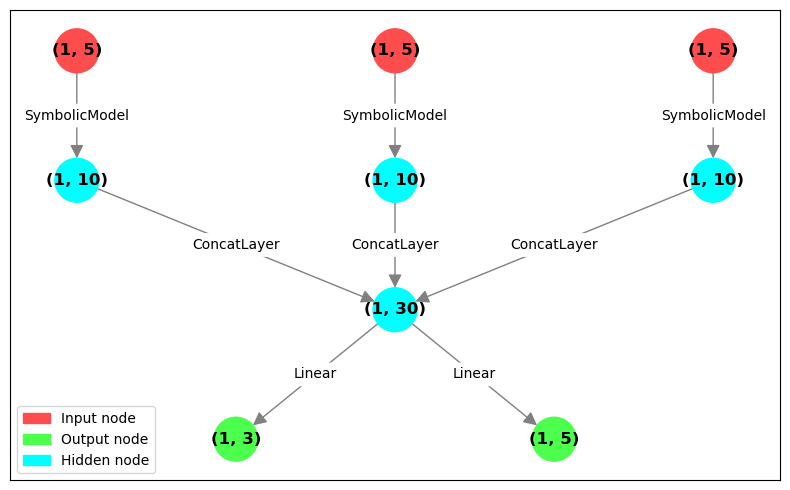

In [14]:
graph_algorithms.draw_graph(model=model, figsize=(8, 5));

If we want, we can even "zoom in" to the inner Symbolic Model. Let's try it:

In [15]:
towers[0].summary()

_________________________________________________
     Layer      Output shape   Params   Parent   
1    Input_1    (None, 5)      0                 
2    Linear_1   (None, 10)     60       1        
3    Linear_2   (None, 10)     110      2        
4*   Linear_3   (None, 10)     110      3        
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________


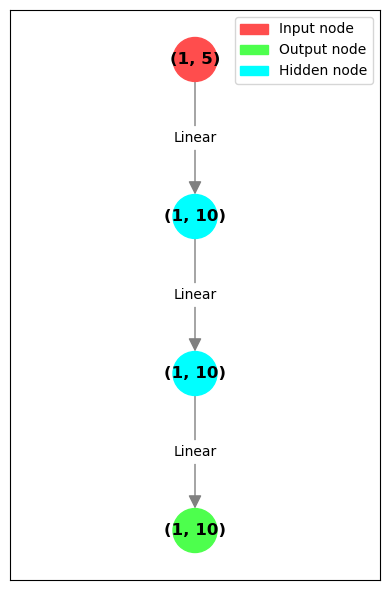

In [16]:
graph_algorithms.draw_graph(model=towers[0], figsize=(4, 6));

This can be useful if the model is complex and has many submodels!

### Subgraphs

We don't need to use all the created nodes. We can use just a subset of them: a subgraph.

Your models can take arbitrary Symbolic Data as input, even if it doesn't come from `Input`.

One thing that is forbidden though is using incomplete inputs, for example when a node depends on a node that is not in its subgraph. Example for this:

In [17]:
a = Input((1,))
b = Input((1,))
c = a + b

try:
    # c depends on a and b, but we don't put b in the inputs
    SymbolicModel(inputs=(a,), outputs=(c,))
except AssertionError as e:
    print(e)

Node <SymbolicTensor at 0x7f3142fc4160; 2 parents; 0 children> depends on the output of a foreign node! Perhaps you set the wrong inputs?


Let's use previous graph as an example for using subgraphs to create new models.

Let's say we want a new model that shares weights with the existing one.
We want to omit the tower 1 and tower 3 computations and we'll put their outputs in `inputs`.

This way we will be able to provide them by hand and the computation will be omitted.

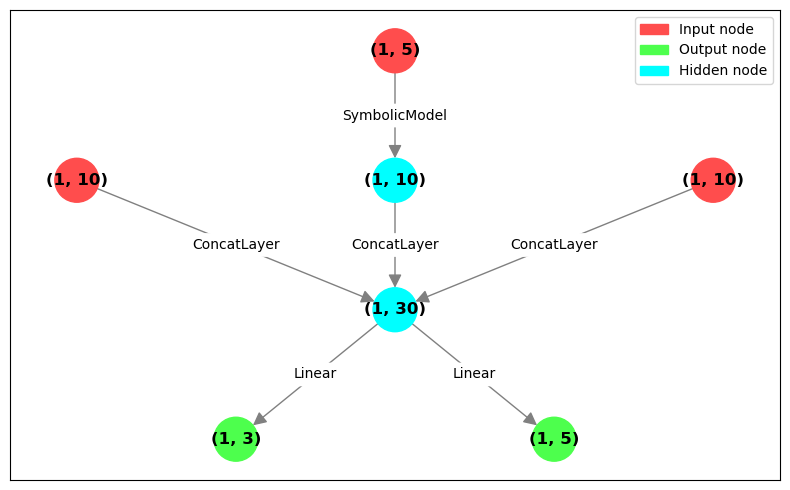

In [18]:
input1 = tower_outputs[0]
input2 = inputs[1]
input3 = tower_outputs[2]

graph_algorithms.draw_graph(inputs=(input1, input2, input3), outputs=(out1, out2), figsize=(8, 5));

In [19]:
model = SymbolicModel(inputs=(input1, input2, input3), outputs=(out1, out2))
model.summary()

real_outputs = model(torch.rand(1, 10), torch.rand(1, 5), torch.rand(1, 10))

________________________________________________________
     Layer             Output shape   Params   Parent   
1    Input_1           (None, 10)     0                 
2    Input_2           (None, 5)      0                 
3    Input_3           (None, 10)     0                 
4    SymbolicModel_1   (None, 10)     390      2        
5    ConcatLayer_1     (None, 30)     0        1,4,3    
6*   Linear_1          (None, 5)      155      5        
7*   Linear_2          (None, 3)      93       5        
Total params: 638
Trainable params: 638
Non-trainable params: 0
________________________________________________________


## Symbolic API in real models

Let us create and train a small ResNet example that will work on MNIST dataset.

To train the model quickly, you need to have CUDA capable device. On Colab, be sure to set "Hardware accelerator" to "GPU".

In this notebook, if CUDA is not detected, we'll automatically use a smaller neural network and a shorter training.

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [21]:
# Creating dataset

ds = torchvision.datasets.MNIST(root=".", download=True, transform=torchvision.transforms.ToTensor())
train, valid = torch.utils.data.random_split(ds, [50000, 10000])

train_dl = torch.utils.data.DataLoader(
    train, batch_size=100, shuffle=True, drop_last=True, pin_memory=True, num_workers=1
)
valid_dl = torch.utils.data.DataLoader(
    valid, batch_size=100, shuffle=False, drop_last=True, pin_memory=True, num_workers=1
)

In [22]:
def create_model_gpu():
    def shortcut_func(x, channels, stride):
        if x.channels != channels or stride != 1:
            return x(nn.Conv2d(x.channels, channels, kernel_size=1, bias=False, stride=stride))
        else:
            return nn.Identity()(x)

    inputs = Input(batch_shape=(100, 1, 28, 28))
    flow = inputs(nn.Conv2d(inputs.channels, 16, 3, padding=1))

    for group_size, width, stride in [(2, 16, 1), (2, 32, 2), (2, 64, 2)]:
        for _ in range(group_size):
            shortcut = shortcut_func(flow, width, stride)

            flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
            flow = nn.Conv2d(flow.channels, width, 3, stride, 1)(flow)
            flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
            flow = nn.Conv2d(flow.channels, width, 3, 1, 1)(flow)

            flow = flow + shortcut
            stride = 1

    flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
    flow = nn.MaxPool2d(kernel_size=flow.HW)(flow)(nn.Flatten())
    outs = nn.Linear(flow.features, 10)(flow)
    return inputs, outs


def create_model_cpu():
    def shortcut_func(x, channels, stride):
        if x.channels != channels or stride != 1:
            return x(nn.Conv2d(x.channels, channels, kernel_size=1, bias=False, stride=stride))
        else:
            return nn.Identity()(x)

    inputs = Input(batch_shape=(100, 1, 28, 28))
    flow = inputs(nn.Conv2d(inputs.channels, 4, 3, padding=1))

    for group_size, width, stride in [(2, 4, 2), (2, 16, 2), (2, 32, 2)]:
        for _ in range(group_size):
            shortcut = shortcut_func(flow, width, stride)

            flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
            flow = nn.Conv2d(flow.channels, width, 3, stride, 1)(flow)
            flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
            flow = nn.Conv2d(flow.channels, width, 3, 1, 1)(flow)

            flow = flow + shortcut
            stride = 1

    flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
    flow = nn.MaxPool2d(kernel_size=flow.HW)(flow)(nn.Flatten())
    outs = nn.Linear(flow.features, 10)(flow)
    return inputs, outs


if device.type == "cuda":
    inputs, outputs = create_model_gpu()
else:
    inputs, outputs = create_model_cpu()

model = SymbolicModel(inputs=inputs, outputs=outputs).to(device)
optimizer = torch.optim.Adam(model.parameters())

It is a large graph to draw! But let's try it anyway...

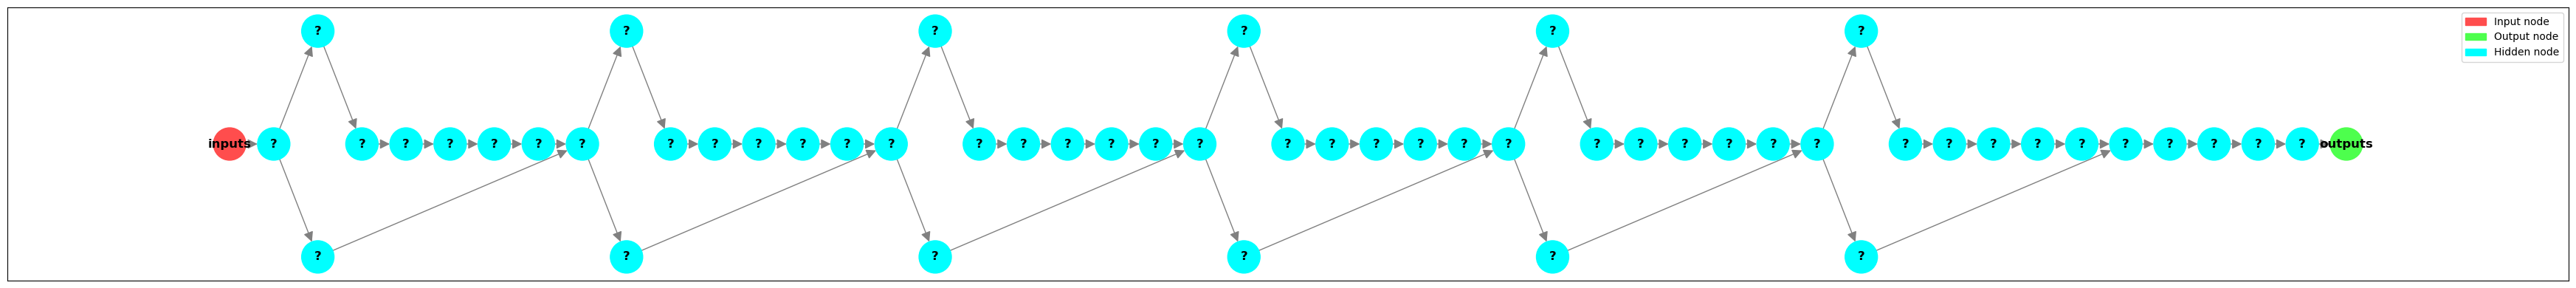

In [23]:
graph_algorithms.draw_graph(
    model=model,
    edge_text_func=lambda x: "",
    node_text_namespace=globals(),
    rotate_graph=True,
    figsize=(35, 4),
);

In [24]:
def traininig(model, optimizer, epochs):
    model.train()

    loss_fn = nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        mean_acc = 0
        mean_acc_n = 0

        for x, y in train_dl:
            x = x.to(device)
            y = y.to(device)

            model.zero_grad()
            outs = model(x)

            loss = loss_fn(outs, y)
            loss.backward()
            optimizer.step()

            accuracy = torch.mean((outs.argmax(1) == y).to(torch.float)).detach().cpu()
            mean_acc += accuracy * x.shape[0]
            mean_acc_n += x.shape[0]

        print(f"Average training accuracy in epoch {epoch + 1}: {mean_acc / mean_acc_n * 100 : <6.3f}%")


traininig(model, optimizer, epochs=5 if device.type == "cuda" else 2)

  0%|          | 0/5 [00:00<?, ?it/s]

Average training accuracy in epoch 1: 95.486%
Average training accuracy in epoch 2: 99.012%
Average training accuracy in epoch 3: 99.230%
Average training accuracy in epoch 4: 99.376%
Average training accuracy in epoch 5: 99.466%


In [25]:
def evaluation(model):
    model.eval()

    mean_acc = 0
    mean_acc_n = 0

    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for x, y in valid_dl:
            x = x.to(device)
            y = y.to(device)
            outs = model(x)
            accuracy = torch.mean((outs.argmax(1) == y).to(torch.float)).detach().cpu()
            mean_acc += accuracy
            mean_acc_n += 1

    print(f"Average validation accuracy: {mean_acc / mean_acc_n * 100 : <6.3f}%")


evaluation(model)

Average validation accuracy: 99.030%


## Acceleration

Hurray! We've trained a network that is pretty accurate. What else can we improve?

Maybe performance? With Pytorch Symbolic you can enable CUDA Graphs using just one argument.

This will work especially well for models with many small layers or where CPU calls are slow in comparison to GPU kernel execution.

In [26]:
if torch.cuda.is_available():
    inputs, outputs = create_model_gpu()
    model = SymbolicModel(inputs=inputs, outputs=outputs, enable_cuda_graphs=True)
    optimizer = torch.optim.Adam(model.parameters())

    traininig(model, optimizer, epochs=5)
    evaluation(model)
else:
    print("CUDA Graphs require CUDA capable device!")

  0%|          | 0/5 [00:00<?, ?it/s]

Average training accuracy in epoch 1: 95.528%
Average training accuracy in epoch 2: 99.016%
Average training accuracy in epoch 3: 99.230%
Average training accuracy in epoch 4: 99.430%
Average training accuracy in epoch 5: 99.450%
Average validation accuracy: 99.110%


# Automatic code generation

Pytorch Symbolic generates forward function source automatically. We are able too peek what was generated.

We tweak one of the constants of code generator, just for the sake of presentation:

In [27]:
from pytorch_symbolic import config, add_to_graph

config.CODEGEN_MIN_LOOP_LENGTH = 2

Now we define the model:

In [28]:
x1 = Input(shape=(3, 32, 32))

x2 = nn.Conv2d(x1.C, 16, 3, padding=1)(x1)
x3 = nn.Conv2d(x2.C, 16, 3, padding=1)(x2)
x4 = nn.Conv2d(x3.C, 16, 3, padding=1)(x3)

x11 = nn.Conv2d(x4.C, 16, 3, padding=1)(x4)
x12 = nn.Conv2d(x11.C, 16, 3, padding=1)(x11)
x13 = nn.Conv2d(x12.C, 16, 3, padding=1)(x12)
x14 = nn.Conv2d(x13.C, 16, 3, padding=1)(x13)
x15 = nn.Conv2d(x14.C, 16, 3, padding=1)(x14)

x21 = nn.Conv2d(x4.C, 16, 3, padding=1)(x4)
x22 = nn.Conv2d(x21.C, 16, 3, padding=1)(x21)
x23 = nn.Conv2d(x22.C, 16, 3, padding=1)(x22)

x5 = add_to_graph(torch.concat, [x15, x23], dim=1)
x6 = nn.Flatten()(x5)
x7 = nn.Linear(x6.features, 1)(x6)

model = SymbolicModel(inputs=x1, outputs=x7)

In [29]:
print(model._generated_forward_source)

def forward(self,y00):
    l = self._execution_order_layers
    x02 = y00
    for layer in l[0:3]:
        x02 = layer(x02)
    x07 = x02
    for layer in l[3:8]:
        x07 = layer(x07)
    x10 = x02
    for layer in l[8:11]:
        x10 = layer(x10)
    x11 = l[11](x07, x10)
    o00 = x11
    for layer in l[12:14]:
        o00 = layer(o00)
    return o00



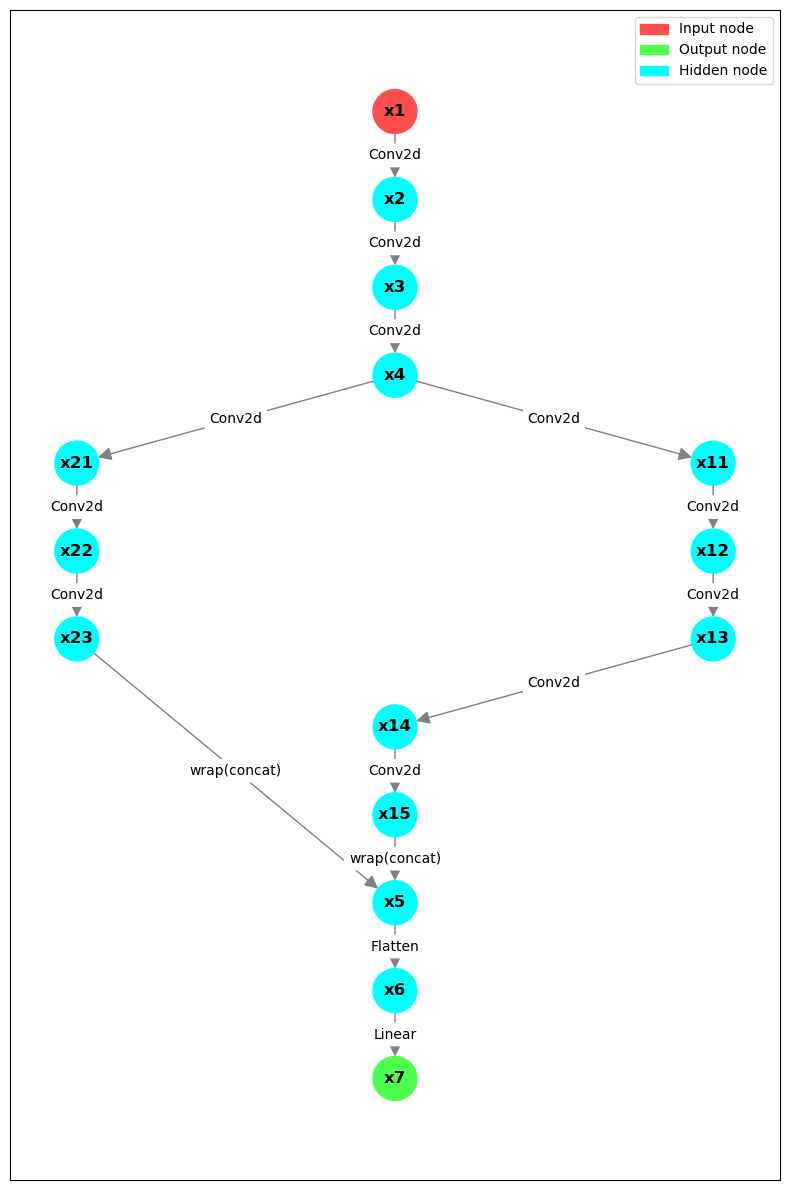

In [30]:
graph_algorithms.draw_graph(model=model, node_text_namespace=globals(), figsize=(8, 12));